In [183]:
# loading the requeired libraries and modules 

# Basic modules 
import os
import numpy as np
import pandas as pd
import string
import re
import nltk
import glob
import PIL
from PIL import Image
from pickle import dump, load

# Image preprocessing modules
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img,load_img
from keras.utils import to_categorical

# Text preprocessing modules
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

# Model related modules
from keras.models import Model, Sequential
from keras.applications import InceptionV3, ResNet50, VGG16
from keras.applications.inception_v3 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
#from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout, Bidirectional, LSTM, Embedding, Activation, Reshape,merge
from keras.optimizers import Adam, RMSprop, Adadelta, Adamax


# visulization modules
import matplotlib.pyplot as plt



In [184]:
def load_txt_data(src,trg):
    
    ''' 
    This function is to load the text data of captions, train images names,
    test image names and dev-set image names.
    
    def load_txt_data(src,trg):
        return txt_data
    
    src: source directory location of the text files of tokens and image names
    trg: target text file to load
    
    txt_data: loaded text file data'''
    
    filedir = os.path.join(src,trg)
    file = open(filedir, mode = 'r', encoding = 'utf-8')
    txt_data = file.read()
    file.close()
    return txt_data

# source and target text file directory locations
src = 'F:\\AI_projects\\Image_caption_generator\\Flicker_Text'


token = 'token.txt'
train = 'trainImages.txt'
test =  'testImages.txt'
dev = 'devImages.txt'

# loading text data
text = load_txt_data(src,token)
train_id_txt = load_txt_data(src,train)
test_id_txt = load_txt_data(src,test)
dev_id_txt = load_txt_data(src,dev)

In [185]:
print(text[:1000])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b

In [186]:
def clean_captions(text):  
    
    ''' This fuction cleans the captions for the images and create the 
        directory with image id as key and list of captions of image as values.
        
        def clean_captions(text):
            return Image_ids, captions
            
        text: text file of tokens which need to be cleaned 
        Image_ids: list of all image ids for all the images in data
        captions: directory of captions 
        
        '''
    Image_Ids = []
    captions = {}
    
    for line in text.split('\n'):
        
        if len(line) > 2:
            #lower casing the string and splitting lines at tab 
            tokens = line.lower().split('\t')
            #try and except method to bypass empty strings and errors
            try:
                Image_id, Image_des = tokens[0].split('.')[0], tokens[1]
            except:
                continue
            
            #removing punctuations and hangings with regular expressions and string
            #maketrans module
            regex = r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"  
            Image_des = re.sub(regex,"",Image_des) 
            Image_des = Image_des.translate(str.maketrans('','',string.punctuation))
            #removing single words and articles
            Image_des = [word for word in Image_des.split() if len(word)>1 ]
            # remove numebers in tokens
            Image_des = [ word for word in Image_des if word.isalpha()]
            #joining the string as whole caption
            Image_des = ' '.join(Image_des)
        
            #adding image ids to the list of image_ids list
            if Image_id not in Image_Ids:
                Image_Ids.append(Image_id)
            
            # creating an empty dictonary with image ids as keys to store captions
            # values
            if Image_id not in captions:
                captions[Image_id] = []
            captions[Image_id].append(Image_des)

    return Image_Ids, captions

Image_Ids, captions = clean_captions(text)

In [187]:
len(captions)

8092

In [188]:
print(captions['1000268201_693b08cb0e'])
print(captions['1001773457_577c3a7d70'])

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']
['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other']


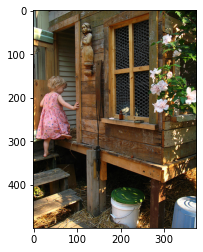

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [189]:
def show_image_captions(images_path,pic):
    x = plt.imread(images_path + pic)
    plt.imshow(x)
    plt.show()
    
images_path = 'Flicker_Dataset/Flicker8k_Dataset/'
pic1 = '1000268201_693b08cb0e.jpg'
pic2 = '1001773457_577c3a7d70.jpg'

show_image_captions(images_path,pic1)
print(captions['1000268201_693b08cb0e'])

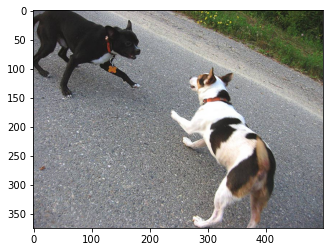

['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other']


In [190]:
show_image_captions(images_path,pic2)
print(captions['1001773457_577c3a7d70'])

In [191]:
def vocabulary(captions):
    
    ''' This function willl generate the set of all the vocablulary in the captions
     
     def vocabulary(captions):
         return vocab
         
     captions: dictionary of image_ids and capitons list for specific image_id
     vocab: set of all the unique words in the captions
     '''
    
    cap_str = ' '.join([desc for key,values in captions.items() for desc in captions[key]])
    words = set(cap_str.split())
    stop = stopwords.words('english')
    vocab = set([ word for word in words if word not in stop])
    return vocab

orig_vocab = vocabulary(captions)
print('Total number of Original Vocabulary Size : {}'.format(len(orig_vocab)))

Total number of Original Vocabulary Size : 8652


In [192]:
def save_descriptions(captions, filename):
    
    ''' This function will save the cleaned captions without puntuation and symbols
    
    save_descirptions(captions, filename):
    
    def save_descriptions(captions, filename):
        return wriing file
    
    
    captions:  This is a dictonary created by clean captions funtion with 
               Image_ids as keys and Image_captions as values 
    filename:  name of the file under which captions need to be saved 
    '''
    lines = list()
    for img_id, img_cap_list in captions.items():
        for cap in img_cap_list:
            lines.append(img_id + ' ' + cap)
        data = '\n'.join(lines)
        f = open(filename, 'w')
        f.write(data)
        f.close()     
        
save_descriptions(captions, 'clean_descriptions.txt')

In [193]:
def IDs_and_Paths(images_path,train,test,dev):
    images = glob.glob(images_path + '*.jpg')
    
    #images id creations
    def image_id(filename):
        image_id = [line.split('.')[0] for line in filename.split('\n') if len(line) > 2]
        image_id = set(image_id)
        return image_id
    
    #image path creations
    def image_path(image_id):
        return [os.path.join(images_path, Id) + '.jpg' for Id in image_id if Id in Image_Ids]
    
    train_id = image_id(train)
    test_id = image_id(test)
    dev_id = image_id(dev)
    
    train_img_path = image_path(train_id)
    test_img_path = image_path(test_id)
    dev_img_path = image_path(dev_id)
    
    IDs = [train_id, test_id,dev_id]
    Paths = [train_img_path, test_img_path, dev_img_path]
    
    return images, IDs, Paths


images, Id_list, PATH_list = IDs_and_Paths(images_path, train_id_txt,test_id_txt,dev_id_txt)


#def train_test_descriptions(ID_list, PATH_list, descripitions):
train_ids, test_ids, dev_ids = Id_list[0], Id_list[1], Id_list[2]
train_path, test_path, dev_path = PATH_list[0], PATH_list[1], PATH_list[2] 


In [194]:
print(len(images))
print(len(train_ids))
print(len(train_path))


print(len(test_ids))
print(len(test_path))

print(len(dev_ids))
print(len(dev_path))


8091
6000
6000
1000
1000
1000
1000


In [195]:
def load_clean_descriptions(filename, ID_set):
    
    txt = load_txt_data('',filename)
    clean_captions = dict()
    
    for line in txt.split('\n'):
        tokens = line.split()
        img_id, img_cap = tokens[0], tokens[1:]
        if img_id in ID_set:
            if img_id not in clean_captions:
                clean_captions[img_id] = list()
            process_cap = 'startseq' +' '+  ' '.join(img_cap) +' '+'endseq'
            clean_captions[img_id].append(process_cap)
    return clean_captions

train_captions = load_clean_descriptions('clean_descriptions.txt', train_ids)

In [215]:
# processing the data 

# creating the list of all the training captions


def training_corpus(cap_dict, thresh):
    
    # creating list of all words in caption dictonary and creating sting
    cap_list = [cap for Id,cap_list in cap_dict.items() for cap in cap_list]
    cap_string = ' '.join(cap_list)
    
    # creating word count dictonary and threshold vocabulary list 
    word_count = {}
    for word in cap_string.split():
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1
    
    vocab = [w for w,f in word_count.items() if f >= thresh]
    
    # creating the word to index and index to word dictonarys
    def word_index_mapping(vocab):
        wordtoidx, idxtoword = {}, {}
        idx = 1
        for word in vocab:
            wordtoidx[word] = idx
            idxtoword[idx] = word
            idx += 1
        return wordtoidx, idxtoword
        
    wordtoidx, idxtoword = word_index_mapping(vocab)
    vocab_size = len(vocab) + 1    
    
    #finding maximum length caption in the caption dictonary
    max_cap_len = max([len(cap.split()) for cap in cap_list])
    
    return  vocab, wordtoidx, idxtoword, vocab_size, max_cap_len

vocab, wordtoidx, idxtoword, vocab_size, max_cap_len = training_corpus(train_captions,thresh = 10)

In [216]:
max_cap_len
        

34

In [222]:
# glove embeddings

embedding_dict = {}

glove = open(os.path.join('Glove', 'glove.6B.200d.txt'), encoding = 'utf-8')
for line in glove:
    embed = line.split()
    word, coefs = embed[0], np.asarray(embed[1:], dtype = 'float32')
    embedding_dict[word] = coefs

embedding_dim = 200
embedding_matrix = np.zeros( (vocab_size,embedding_dim))

for word, idx in wordtoidx.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [ ]:
# extract features from each photo in the training directory

def extract_features(images):
    
    feat_model = InceptionV3(weights = 'imagenet')
    feat_model = Incept





In [108]:
# load the inception model

model = InceptionV3(weights = 'imagenet')


# Create a new model, by removing the last layer (output layer)
#from the inception v3
new_model = Model(model.input, model.layers[-2].output)


def image_preprocess(images):
    
    # convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(images, target_size = (299,299))
    # convert PIL image to numpy arry of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    #x = np.expand_dims(x, axis =0)
    x = image.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# Function to encode a given image into a vector of size (2048, )
def encode(images):
    image = image_preprocess(images)
    fea_vec = new_model.predict(image)
    fea_vec = np.reshape( fea_vec, fea_vec.shape[1]) # reshape from (1,2048)
     # to (2048,)     
    return fea_vec



In [144]:
encoding_train = {}
for images in train_path:
    encoding_train[images[len(images_path):]] = encode(images)
train_features = encoding_train


encoding_test = {}
for images in test_path:
    encoding_test[images[len(images_path):]] = encode(images)
test_features = encoding_test



In [145]:
import pickle

# Save the bottleneck train features to disk
with open("pickle/encoded_train_images.pkl", "wb") as encoded_train_pickle:
    pickle.dump(encoding_train, encoded_train_pickle)
    
# Save the bottleneck train features to disk
with open("pickle/encoded_test_images.pkl", "wb") as encoded_test_pickle:
    pickle.dump(encoding_test, encoded_test_pickle)



In [22]:
type(train_path)

list

In [25]:
print(len(encoding_train))

100


In [223]:
inputs1 = Input(shape = (2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

inputs2 = Input(shape = (max_cap_len,))
se1 = Embedding(vocab_size, embedding_dim,mask_zero = True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = merge.add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 34, 200)      330400      input_22[0][0]                   
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 2048)         0           input_21[0][0]                   
____________________________________________________________________________________________

In [224]:
# model triaining

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# define checkpoint callback
#filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
#model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

In [225]:
# create sequences of images, input sequences and output words for an image

def create_sequence(captions, features, wordtoidx,max_cap_len,num_img_per_batch):
    X1, X2, y = [], [], []
    n = 0
    while True:
        # iterate over each images ids
        for img_id, cap_list in captions.items():
            n += 1
            
            # retrieve the photo features
            feature = features[img_id+ '.jpg']
            # iterate over individul caption in caption list
            for cap in cap_list:
                #encode sequence
                seq = [wordtoidx[word] for word in cap.split(' ') if word in wordtoidx]
                # split sequence into text feature and text target pairs
                
                for i in range(1, len(seq)):
                    txt_feat, txt_tar = seq[:i], seq[i]
                
                    # pad input sequences
                    in_seq = pad_sequences([txt_feat], maxlen = max_cap_len)[0]
                    # encode output sequences
                    out_seq = to_categorical([txt_tar], num_classes = vocab_size)[0]
                
                    # store 
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == num_img_per_batch:
                yield ( [np.array(X1), np.array(X2)], np.array(y))
                
                X1, X2, y = list(), list(), list()
                
                n = 0
                

In [234]:
epochs = 1
batch_size = 60
steps = len(train_captions)//batch_size 

generator = create_sequence(train_captions, train_features, wordtoidx, max_cap_len, batch_size)

model.fit(generator, epochs = epochs, steps_per_epoch = steps, verbose = 1)

Epoch 1/1
100/100 [==============================] - 1403s 14s/step - loss: 4.7012: 1:24 - lo


In [235]:
max_cap_len


34

In [236]:
def greedySearch(features):
    in_text = 'startseq'
    for i in range(max_cap_len):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen = max_cap_len)
        yhat = model.predict([features,sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

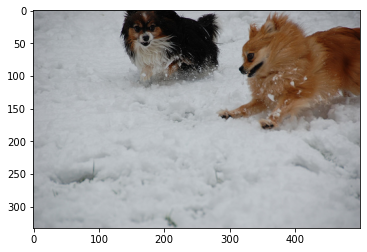

Greedy Search: dog is running in the grass
Beam Search, K = 3: black dog is running in the grass
Beam Search, K = 5: black dog is running in the grass
Beam Search, K = 7: black dog is running in the grass
Beam Search, K = 10: black dog is running in the grass


In [247]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search(image, beam_index = 10))

In [128]:
cap

''

In [246]:
def beam_search(image, beam_index = 3):
    start = [wordtoidx["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_cap_len:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_cap_len, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idxtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption